<a href="https://colab.research.google.com/github/vishnureddys/movie-recommender-system/blob/main/movie_recommeder_withoutComments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

In [1]:
#installing Apache Spark on Colab
import os

In [2]:
#Downloading Java JDK version 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
#Downloading and installing Apache Spark along with Findspark
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q Findspark


In [4]:
# Change Java Version Frim JDK-11 to JDK-8
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [5]:
#Now launching a spark session on colab

import findspark
findspark.init()

#Start Apache Spark session and context
import pyspark
from pyspark.sql import SQLContext

sc = pyspark.SparkContext(appName='bd_project')
sqlContext = SQLContext(sc)

print('Master : ', sc.master)
print('Cores  : ', sc.defaultParallelism)

Master :  local[*]
Cores  :  2


In [6]:
# Required Later
sqlContext.sparkSession.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [7]:
#The packages we will be needing
!pip install koalas

     |████████████████████████████████| 778kB 4.9MB/s 


In [8]:
# Default Packages (available by Default in Google Colab)
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random
from pprint import pprint
from matplotlib.lines import Line2D

# Downloaded Packages (not available by Default)
import databricks.koalas

# PySpark Utilities
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics

# Random Seed
SEED = 1492

# Set-up
plt.style.use('seaborn')

In [9]:
from google.colab import drive
drive.mount('/content/drive');

Mounted at /content/drive


In [10]:
!ls "drive/My Drive/MovieRecommender"

Data  Results


In [11]:
#Path to Data Folder
DATA_PATH = "drive/My Drive/MovieRecommender/Data"

#Path to Results Folder
RESULTS_PATH = "drive/My Drive/MovieRecommender/Results"

# Data Preprocessing

In [13]:
class MovieLensDatasets(object):
    """
    Class for loading and preprocesing MovieLens Dataset
    """
    def __init__(self, ratings, movies, links, personalRatings, debug=True, debugLimit=10000):
        # Load Existing Data
        if debug:
            debugLimit = debugLimit
            ratings = ratings.limit(debugLimit)
        else:
            ratings = ratings      

        self.ratings = ratings
        self.movies = movies
        self.links = links
        self.personalRatings = personalRatings

        # Create New DataFrame
        users = ratings.select('userId').distinct()
        self.users = users

    def preprocessing(self):
        # Preprocess MovieLens Ratings
        self.ratings = self.ratings.withColumn('rating',
        F.col('rating').cast('double')).drop('timestamp') \
        .withColumn('userId', F.col('userId').cast('int')) \
        .withColumn('movieId', F.col('movieId').cast('int'))

        # Preprocess Personal IMDb Ratings To MovieLens Ratings
        self.personalRatings = self.personalRatings.select(['Const',
                                                'Your Rating']) \
        .withColumnRenamed('Const', 'imdbId') \
        .withColumnRenamed('Your Rating', 'personalRating')

        self.personalRatings = self.personalRatings \
        .withColumn('personalRating', F.col('personalRating').cast('double')*0.5) \
        .withColumn('imdbId', F.expr("substr(imdbId, 3)"))

        self.personalRatings = self.personalRatings.join(
        self.links.select('movieId', 'imdbId'), ['imdbId'], how='inner')

        # Insert IMDb Ratings into MovieLens Ratings Dataset
        self.personalRatings = self.personalRatings \
                    .withColumn('userId', F.lit('0'))
        self.personalRatings = self.personalRatings \
                    .select(['userId', 'movieId', 'personalRating']) \
                    .toDF('userId', 'movieId', 'rating')
        self.ratings = self.ratings.union(self.personalRatings)

        # Binarize MovieLens Ratings (if rating >= 3.0, then 1.0, else 0.0)
        udf_scale_ratings = F.udf(lambda x: x - 2.5, DoubleType())
        udf_binary_ratings = F.udf(lambda x: 1.0 if x > 0.0 else 0.0, DoubleType())

        self.ratings = self.ratings \
        .withColumn('ratingsScaled', udf_scale_ratings(F.col('rating'))) \
        .withColumn('ratingsBinary', udf_binary_ratings(F.col('ratingsScaled')))

    def get_ratings(self):
        return self.ratings

    def get_movies(self):
        return self.movies

    # Displaying Null Values
    def spark_df_display_null_values(sparkDf):
        print('NaN values ?')
        sparkDf.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in sparkDf.columns]).show()

        print('Null values ?')
        sparkDf.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in sparkDf.columns]).show()

In [16]:
%%time
# Set to True if only testing
# For testing: use debug=True option (subset of all ratings)
debug = False

# Load Datasets
movies = sqlContext \
            .read.format('csv').option("header", "true") \
            .load(DATA_PATH + "/movies.csv")

links = sqlContext \
            .read.format('csv').option("header", "true") \
            .load(DATA_PATH + "/links.csv")

ratings = sqlContext.read \
            .format('csv').option("header", "true") \
            .load(DATA_PATH + "/ratings.csv")

personalRatings = sqlContext \
            .read.format('csv').option("header", "true") \
            .load(DATA_PATH + "/my_IMDB.csv")


# Data Preprocessing
movieLensDatasets = MovieLensDatasets(ratings=ratings, movies=movies,
                                      links=links,
                                      personalRatings=personalRatings,
                                      debug=debug)

movieLensDatasets.preprocessing()
dfRatings = movieLensDatasets.get_ratings() 
dfMovies = movieLensDatasets.get_movies()

CPU times: user 125 ms, sys: 3.38 ms, total: 128 ms
Wall time: 2.15 s


# EDA

In [17]:
dfRatingsKdf = dfRatings.to_koalas()

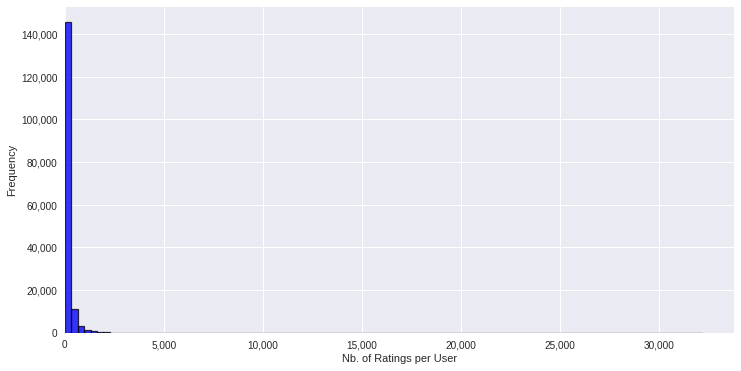

CPU times: user 497 ms, sys: 34.4 ms, total: 532 ms
Wall time: 2min 2s


In [18]:
%%time
f, ax = plt.subplots(figsize=(12,6))
userRatingGroup = dfRatingsKdf.groupby("userId")['rating'].count()
userRatingGroup.hist(bins=100, color='blue', edgecolor='black',
                     linewidth=1.25, alpha=0.78, ax=ax)
ax.set_xlabel('Nb. of Ratings per User')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

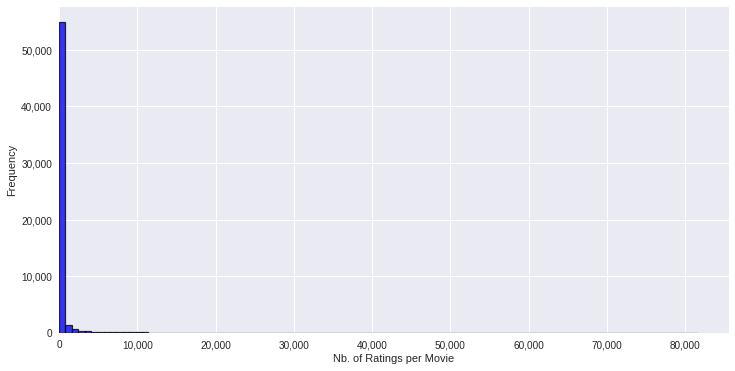

CPU times: user 428 ms, sys: 17.2 ms, total: 445 ms
Wall time: 1min 45s


In [19]:
%%time
f, ax = plt.subplots(figsize=(12,6))
movieRatingGroup = dfRatingsKdf.groupby("movieId")['rating'].count()
movieRatingGroup.hist(bins=100, color='blue', edgecolor='black',
                      linewidth=1.25, alpha=0.78, ax=ax)
ax.set_xlabel('Nb. of Ratings per Movie')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

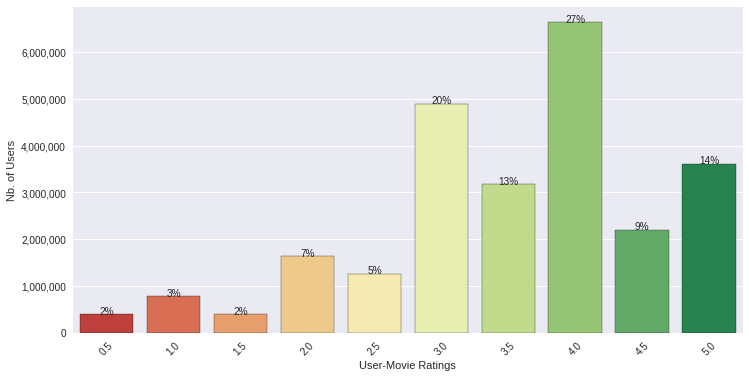

CPU times: user 324 ms, sys: 8.2 ms, total: 332 ms
Wall time: 43.7 s


In [20]:
%%time
movieRatingDistGroup = dfRatingsKdf['rating'].value_counts() \
                                             .sort_index() \
                                             .reset_index() \
                                             .to_pandas()

# Create Matplotlib Figure
fig, ax = plt.subplots(figsize=(12,6))

# Main Figure: Seaborn Barplot
sns.barplot(data=movieRatingDistGroup, x='index', y='rating',
            palette='RdYlGn', edgecolor="black", ax=ax)

# Set Xaxis and Yaxis
ax.set_xlabel("User-Movie Ratings")
ax.set_ylabel('Nb. of Users')
ax.xaxis.set_tick_params(rotation=45)

# Thousand separator on Yaxis labels
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# Add percentage text on top of each bar
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+350,
            '{0:.0%}'.format(height/total),
            ha="center") 

# Display plot
plt.show()

# Model Training

In [23]:
ratingsPrepare = dfRatings.withColumn("userId", F.col("userId").cast('int')) \
                          .withColumn("movieId", F.col("movieId").cast('int'))

dfRatingsTrain, dfRatingsTest = ratingsPrepare.randomSplit([0.8, 0.2],
                                                           seed=SEED)

In [24]:
def catalog_coverage(predicted, catalog, k):
    """
    Computes the catalog coverage for k lists of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    Returns
    ----------
    catalog_coverage:
        The catalog coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and
    serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems
    (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = L_predictions/(len(catalog)*1.0)
    return catalog_coverage


def get_rec_sys_results(relevantDocumentsDf, dfMovies):
    """
    Returns dictionnary of recommender system metrics
    Since Spark ML DataFrame-based doesn't have a
    specific function for evaluating the soundness
    of item recommendations, we will have to use
    Spark MLlib RDD-based API
    """
    # Transform Spark Dataframe into Spark RDD
    relevantDocuments = relevantDocumentsDf.rdd \
        .map(lambda row: (row.predictions, row.groundTruth))
    
    # Get Catalog Coverage
    moviesCatalog = dfMovies.select("movieId") \
                            .orderBy("movieId") \
                            .distinct() \
                            .toPandas()
    predictions = relevantDocumentsDf.select("predictions").toPandas()
    predictionsList = predictions.values.tolist()
    predictionsList = [sublist[0] for sublist in predictionsList]
    cc = catalog_coverage(predicted=predictionsList,
                          catalog=moviesCatalog, k=100)

    # Get Results
    metrics = RankingMetrics(relevantDocuments)
    pk20 = metrics.precisionAt(20)
    ndcg20 = metrics.ndcgAt(20)
    
    results = dict(Pk20=pk20, NDCGk20=ndcg20, CC=cc)
    
    return results


def format_recommendations(rowPreds):
    # From recommendations column extract only items
    # recommended and ignore ratings
    rowPredsList = [row.movieId for row in rowPreds]
    return rowPredsList

udf_format_recommendations = F.udf(lambda x: format_recommendations(x),
                                   ArrayType(IntegerType()))

In [28]:
class PopularityRecommenderModel(object):
    """
    Class for generating movie item recommendations based on movie popularity
    (from average ratings with logarithmic scaling factor that penalizes movies
    with few ratings). By default, only the top 10 rated movies are selected.

    Approach studied during MS Big Data's SD 701 Big Data Mining Course.
    """
    def __init__(self, ratingsTrain, ratingsTest):
        self.ratingsTrain = ratingsTrain
        self.ratingsTest = ratingsTest

    def generate_recommendations_for_all_users(self, topk=10):
        # Get list of top k rated movies
        topRated = self._get_top_k_best_movies(topk=topk)

        # Compare most popular movies with user's personal preferences
        # Important: only keep recommendations with rating over 3/5
        results = self.ratingsTest \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .orderBy('rating', ascending=False) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias('groundTruth')) \
                 .withColumn('predictions', F.array([F.lit(el)
                        for el in topRated])) \
                 .select(['userId', 'predictions', 'groundTruth'])

        return results

    def _get_top_k_best_movies(self, topk):

        # Function
        def _get_mean_rating_w_log_penalty(arr):
            sumRatings, nbRatings = arr[0], arr[1]
            grade = (sumRatings / nbRatings) * math.log(nbRatings)
            return grade

        # UDF
        udf_mean_rating_w_log_penalty = F.udf(
            lambda arr: _get_mean_rating_w_log_penalty(arr),
            DoubleType()
        )

        # Get top k Best Rated Movies
        ranking = self.ratingsTrain.groupBy('movieId') \
              .agg({'rating': 'sum', 'userId': 'count'}) \
              .toDF('movieId', 'sumRating', 'nbRatings')

        ranking = ranking \
        .withColumn("meanLogUserRating",
         udf_mean_rating_w_log_penalty(F.array("sumRating", "nbRatings"))
         ) \
        .sort(['meanLogUserRating', 'nbRatings'], ascending=[False, True]) \
        .limit(topk)

        self.topRatedMovies = ranking
        ratingsTop = [int(row.movieId) for row in ranking.collect()]

        return ratingsTop

In [29]:
%%time
pbrModel = PopularityRecommenderModel(dfRatingsTrain, dfRatingsTest)
resultsPop = pbrModel.generate_recommendations_for_all_users(topk=20)

CPU times: user 85 ms, sys: 23.9 ms, total: 109 ms
Wall time: 2min 16s


In [30]:
%%time
resultsPop.limit(5).orderBy('userId').show(5)

+------+--------------------+--------------------+
|userId|         predictions|         groundTruth|
+------+--------------------+--------------------+
|   148|[318, 296, 858, 5...|[1209, 2959, 293,...|
|   463|[318, 296, 858, 5...|      [32, 785, 762]|
|   471|[318, 296, 858, 5...|[60069, 68954, 95...|
|   496|[318, 296, 858, 5...|[199, 1247, 71579...|
|   833|[318, 296, 858, 5...|[260, 68954, 1, 2...|
+------+--------------------+--------------------+

CPU times: user 108 ms, sys: 17.5 ms, total: 125 ms
Wall time: 6min 15s


In [31]:
%%time
results = get_rec_sys_results(resultsPop, dfMovies)

CPU times: user 2.22 s, sys: 150 ms, total: 2.37 s
Wall time: 12min 57s


In [32]:
pprint(results)

{'CC': 0.00032039472630280506,
 'NDCGk20': 0.09535904901542727,
 'Pk20': 0.06771431044717054}


In [33]:
%%time
_ = pbrModel.generate_recommendations_for_all_users(topk=20)
pbrModel.topRatedMovies \
    .join(dfMovies.select(['movieId', 'title']), 'movieId') \
    .orderBy('meanLogUserRating', ascending=False) \
    .show(20, truncate=False)

+-------+---------+---------+------------------+------------------------------------------------------------------------------+
|movieId|sumRating|nbRatings|meanLogUserRating |title                                                                         |
+-------+---------+---------+------------------+------------------------------------------------------------------------------+
|318    |288098.5 |65251    |48.9472805946674  |Shawshank Redemption, The (1994)                                              |
|296    |266833.0 |63666    |46.35988020423733 |Pulp Fiction (1994)                                                           |
|858    |182023.5 |42077    |46.05962647076001 |Godfather, The (1972)                                                         |
|50     |189592.5 |44245    |45.83942418693688 |Usual Suspects, The (1995)                                                    |
|527    |205136.5 |48311    |45.7966548667675  |Schindler's List (1993)                                 

# Model-Based Collaborative Filtering

Model Training

In [34]:
%%time
tempALS = ALS(maxIter=10, rank=10, regParam=0.1, nonnegative=True,
              userCol='userId', itemCol='movieId', ratingCol='rating',
              coldStartStrategy='drop', implicitPrefs=False, seed=SEED)

mlALSFitted = tempALS.fit(dfRatingsTrain)

CPU times: user 133 ms, sys: 37.9 ms, total: 171 ms
Wall time: 5min 12s


In [35]:
mlALSFitted.save(RESULTS_PATH+"/ALS_MovieLens_25M")

In [36]:

mlALSFitted = ALSModel.load(RESULTS_PATH+"/ALS_MovieLens_25M")

RSME on Test set

In [37]:
%%time
predictions = mlALSFitted.transform(dfRatingsTest)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('RMSE (Test Set):', rmse)

RMSE (Test Set): 0.8147418252855383
CPU times: user 87.5 ms, sys: 29 ms, total: 116 ms
Wall time: 2min 40s


Evaluating Recommedations

In [38]:
resultsALS = mlALSFitted.recommendForAllUsers(20)

resultsALS = resultsALS.withColumn('recommendations',
              udf_format_recommendations(F.col("recommendations"))) \
              .toDF('userId', 'predictions')

In [39]:
resultsALSExpanded = resultsALS \
                        .withColumn("movieId", F.explode("predictions")) \
                        .drop('predictions') \
                        .join(dfMovies, "movieId")

resultsALSKdf = resultsALSExpanded.to_koalas()

MostRecommendedMoviesForAllUsers = resultsALSKdf.groupby(["movieId", "title"])['userId'].count()
MostRecommendedMoviesForAllUsers = MostRecommendedMoviesForAllUsers.sort_values(ascending=False)

In [40]:
%%time
MostRecommendedMoviesForAllUsers.head(20)

CPU times: user 8.77 ms, sys: 1.42 ms, total: 10.2 ms
Wall time: 41.9 ms


movieId  title                                             
151989   The Thorn (1971)                                      158503
194434   Adrenaline (1990)                                     152557
203086   Truth and Justice (2019)                              146142
203882   Dead in the Water (2006)                              143944
183947   NOFX Backstage Passport 2                             137260
202231   Foster (2018)                                         122000
192261   Don't Laugh at My Romance (2008)                      110486
192089   National Theatre Live: One Man, Two Guvnors (2011)    101177
196787   The Law and the Fist (1964)                            94660
197355   Once Upon a Ladder (2016)                              76203
165559   Ο Θανάσης στη χώρα της σφαλιάρας (1976)                71018
194332   Muchas gracias de nada (1980)                          69834
157789   .hack Liminality In the Case of Yuki Aihara            58732
157787   .hack Liminality: In 

In [41]:
resultsALS = resultsALS \
                 .join(
                 dfRatingsTest \
                 .filter(F.col("ratingsBinary")==1.0) \
                 .withColumn('movieId', F.col('movieId').cast('int')) \
                 .groupby("userId") \
                 .agg(F.collect_list("movieId").alias("groundTruth")),
                     'userId'
                 )

# resultsALS.orderBy('userId').limit(10).show(10)

In [42]:
%%time
resultsALSMetrics = get_rec_sys_results(resultsALS, dfMovies)

CPU times: user 2.31 s, sys: 259 ms, total: 2.57 s
Wall time: 27min 18s


In [43]:
pprint(resultsALSMetrics)

{'CC': 0.0036364801435368375,
 'NDCGk20': 3.6917610374570712e-06,
 'Pk20': 3.4007716660071253e-06}


# Results

In [44]:
results = {'CC': 0.00032039472630280506,
 'NDCGk20': 0.09535904901542727,
 'Pk20': 0.06771431044717054}

In [45]:
results['RMSE'] = 'N/A'
resultsALSMetrics['RMSE'] = rmse

In [46]:
modelResults = pd.DataFrame([results, resultsALSMetrics],
                             index=['PopRec', 'CF-ALS'])

modelResults.transpose()

,PopRec,CF-ALS
CC,0.000320395,0.00363648
NDCGk20,0.095359,3.69176e-06
Pk20,0.0677143,3.40077e-06
RMSE,N/A,0.814742


Testing with my values

In [47]:
%%time
dfRatingsTrain.filter(F.col("userId")==0).count()

CPU times: user 34.1 ms, sys: 9.53 ms, total: 43.6 ms
Wall time: 2min 12s


57

In [48]:
%%time
predictionsPerso = resultsALS.filter(F.col("userId")==0) \
                             .select(F.explode("predictions") \
                             .alias("movieId")) \
                             .join(dfMovies.select(["movieId", "title"]),
                                   "movieId") \
                             .join(dfRatings.filter(F.col("userId")==0),
                                   ['movieId'], how='left')

predictionsPerso.select(["title", "rating"]).show(10, truncate=False)

+-------------------------------------+------+
|title                                |rating|
+-------------------------------------+------+
|Foster (2018)                        |null  |
|The Thorn (1971)                     |null  |
|Hoaxed (2019)                        |null  |
|My Best Enemy (2006)                 |null  |
|The Challengers (1990)               |null  |
|Fracchia la belva umana (1981)       |null  |
|La leggenda di Al, John e Jack (2002)|null  |
|Heroes Above All (2017)              |null  |
|Of Two Minds (2012)                  |null  |
|King for a Day (1983)                |null  |
+-------------------------------------+------+
only showing top 10 rows

CPU times: user 149 ms, sys: 42.2 ms, total: 191 ms
Wall time: 12min 52s
